# Análisis Exploratorio de Datos

In [1]:
# Agregamos la raíz del proyecto al path y para importar los paquetes de src 
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Importamos librerías necesarias
import src.data.preprocess as pp
import src.visualization.config_vis as configv
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Seteamos configuración para los gráficos
configv.set_custom_style()

Estilo de gráficos aplicado correctamente.


### 1. Carga de Datos 

In [2]:
# Cargamos el dataset limpio
df = pp.preprocesar_datos()

Iniciando preprocesamiento...
Registros iniciales: 30000
Registros eliminados por inconsistencias de deuda: 1739
Registros eliminados por inconsistencias factura-pago: 2769
Registros finales: 25492
Preprocesamiento completado.


In [3]:
# Vista general del dataset
print(f'(filas, columnas) = {df.shape}')
df.head()

(filas, columnas) = (25492, 9)


,limite_credito,genero,educacion,estado_civil,edad,meses_deuda_sep,pago_sep,factura_sep,default_oct
0,20000,2,2,1,24,-2,0,0,1
2,90000,2,2,2,34,0,15549,5000,0
3,50000,2,2,1,37,0,29547,1000,0
4,50000,1,2,1,57,0,19131,679,0
5,50000,1,1,2,37,0,20024,800,0


### 2.1 Análisis Univariado

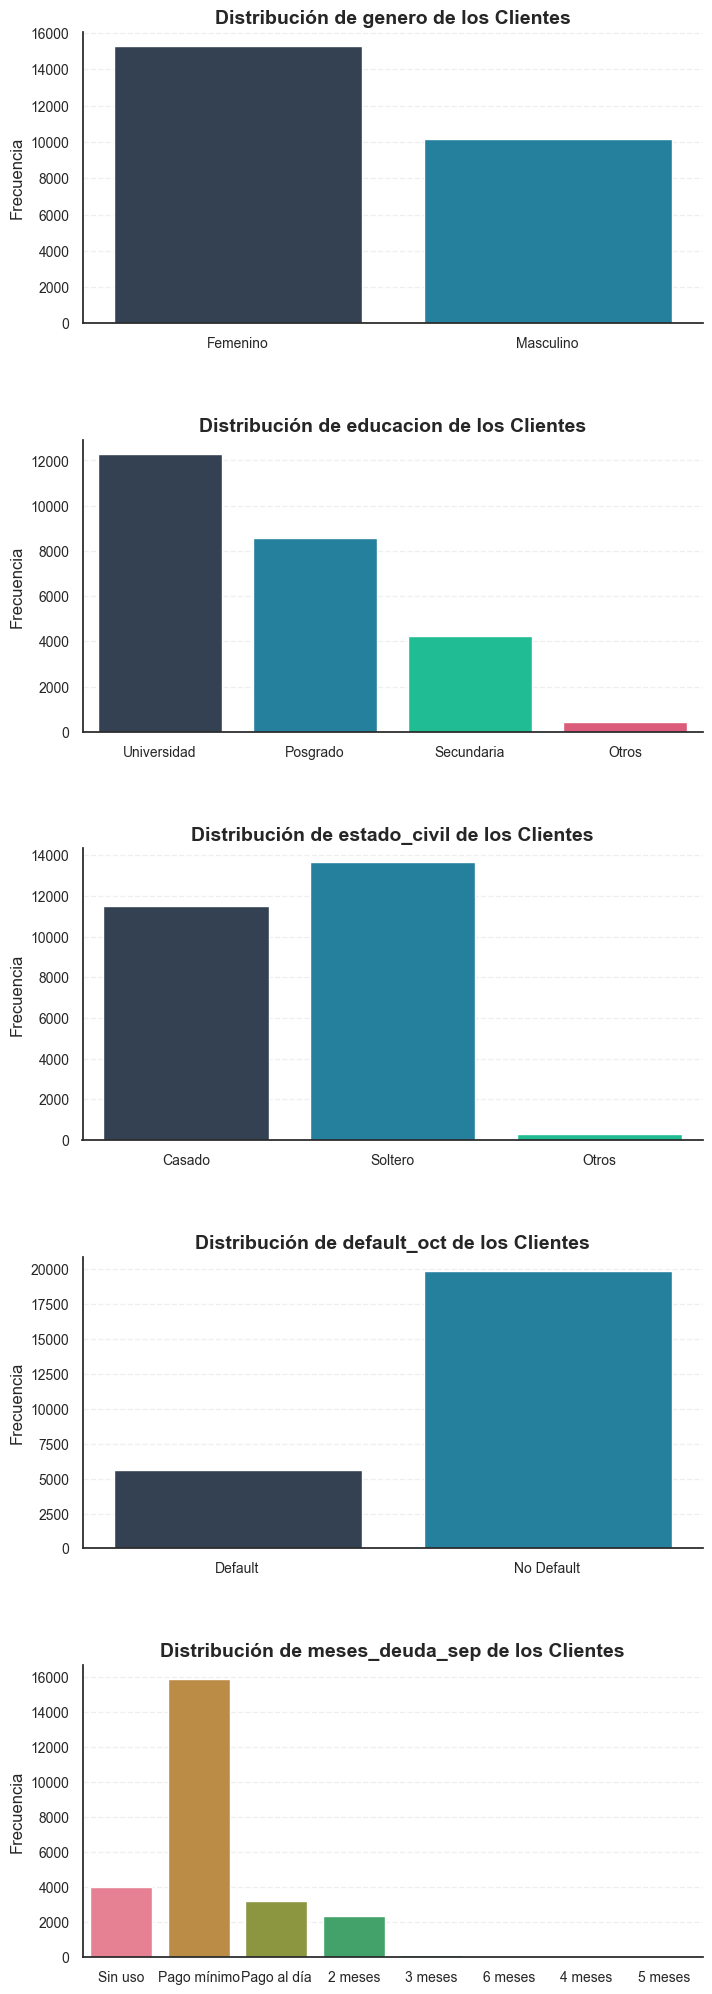

In [4]:
# Guardamos las variables categóricas para generar gráficos de barras y observar la distribución
col_cat = ['genero', 'educacion', 'estado_civil', 'default_oct', 'meses_deuda_sep']

# Creamos una copia del dataframe para mapear las categorías con los numeros
df_vis = df.copy()

# Definimos los mapeos
diccionarios_mapeo = {
    'genero': {1: 'Masculino', 2: 'Femenino'},
    'educacion': {1: 'Posgrado', 2: 'Universidad', 3: 'Secundaria', 4: 'Otros'},
    'estado_civil': {1: 'Casado', 2: 'Soltero', 3: 'Otros'},
    'default_oct': {0: 'No Default', 1: 'Default'},
    'meses_deuda_sep': {-2: 'Sin uso', -1: 'Pago al día', 0: 'Pago mínimo',
         2: '2 meses', 3: '3 meses', 4: '4 meses', 5: '5 meses', 6: '6 meses'}
}

# Aplicamos el mapeo al dataset auxiliar
for col in col_cat:
    if col in diccionarios_mapeo:
        df_vis[col] = df_vis[col].map(diccionarios_mapeo[col])

# Gráficos de barras
fig, ax = plt.subplots(nrows=len(col_cat), ncols=1, figsize=(8, 25))
fig.subplots_adjust(hspace=0.40)

for i, col in enumerate(col_cat):
    sns.countplot(x=col, data=df_vis, ax=ax[i], hue=col)
    ax[i].set_title(f'Distribución de {col} de los Clientes')
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Frecuencia')

plt.show()

**Observaciones:**

Niveles de las variables de interés:
- `genero`: 2 (Femenino, Masculino)
- `educacion`: 4 (Posgrado, Universidad, Secundaria, Otros). En este caso la gran mayoría de clientes alcanzaron un nivel universitario o superior
- `estado_civil`: 3 (Casado, Soltero, Otros). La mayor parte de los clientes son solteros
- `default_oct`: 2 (Sí, No). La gran mayoría de los clientes no caen en default en octubre. Aca se evidencia un desbalance entre las clases de la variable a predecir que deberá ser tenido en cuenta a la hora de desarrollar un modelo de ML
- `meses_deuda_sep`: (Sin Uso, Pago Mínimo, Pago al día, X meses). La gran mayoría de los clientes presenta el pago mínimo de su tarjeta en el mes de septiembre.

---

In [5]:
# Estadísticas de las variables numéricas
df.drop(columns=col_cat).describe()

,limite_credito,edad,pago_sep,factura_sep
count,25492.000000,25492.000000,25492.000000,25492.000000
mean,163228.843559,35.357092,43298.034874,5626.481916
std,128605.000470,9.226306,62188.594355,18902.855357
min,10000.000000,21.000000,-339603.000000,0.000000
25%,50000.000000,28.000000,1476.750000,326.000000
50%,130000.000000,34.000000,19800.000000,1701.000000
75%,230000.000000,41.000000,56149.500000,4328.750000
max,1000000.000000,79.000000,961664.000000,528666.000000


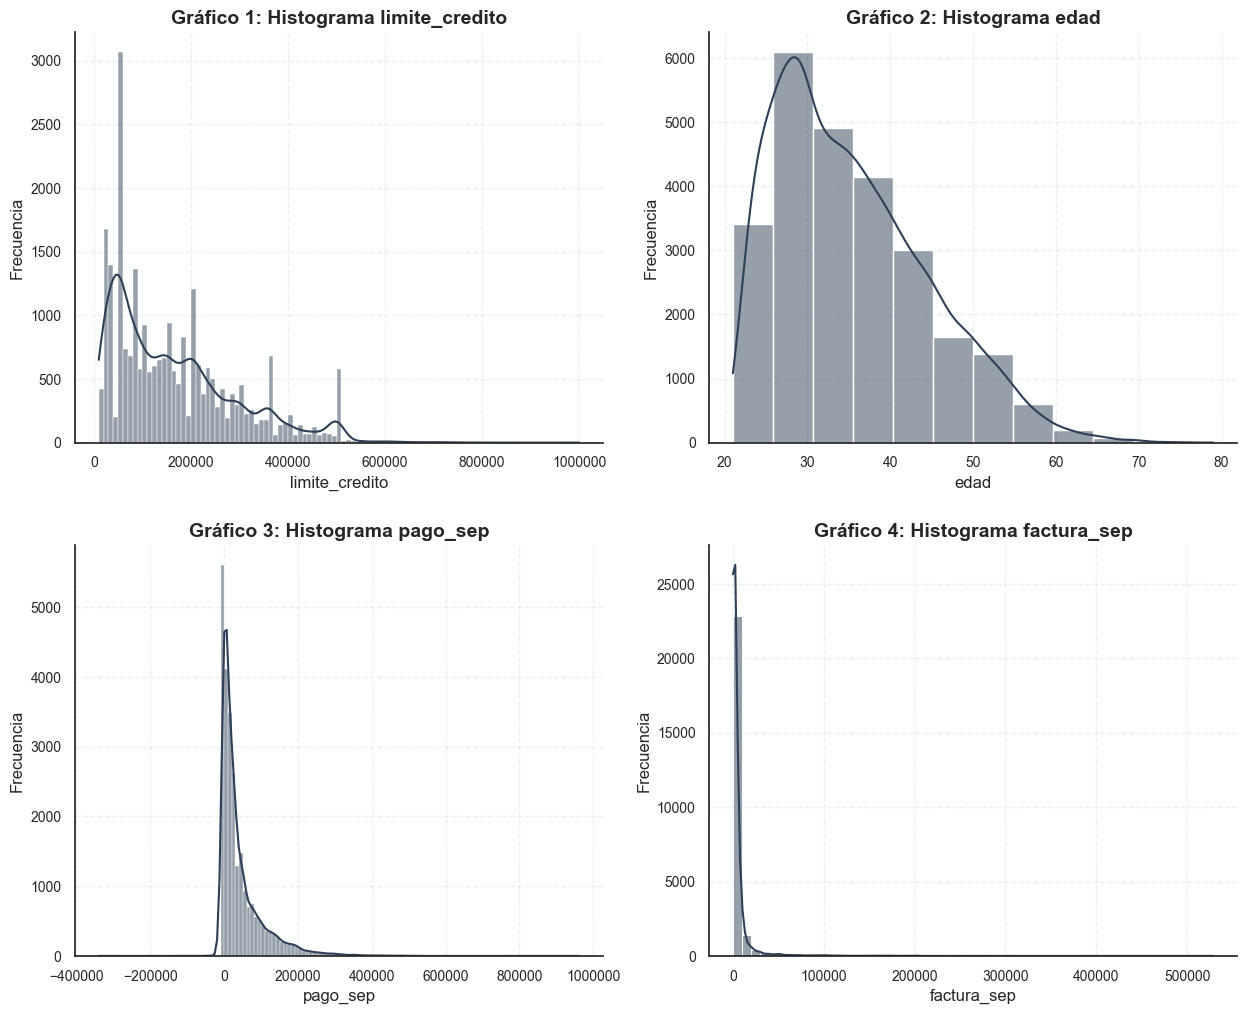

In [6]:
# Guardamos las variables numéricas
col_num = ['limite_credito', 'edad', 'pago_sep', 'factura_sep']


fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,12))
fig.subplots_adjust(hspace=0.25)
ax = ax.flatten() # flatten() aplana la matriz de 2x2 en un vector iterable para las gráficas

for i, col in enumerate(col_num):
    if col == 'edad':
        wbin = 5
    else:
        wbin = 10000
    sns.histplot(x=col, data=df_vis, ax=ax[i], binwidth = wbin, kde=True)
    ax[i].set_title(f'Gráfico {i+1}: Histograma {col}')
    ax[i].set_xlabel(f'{col}')
    ax[i].set_ylabel("Frecuencia")
    ax[i].ticklabel_format(style='plain', axis='x')



**Observaciones:**
- Aunque la media de `edad` es 35 años, la curva de densidad muestra que la base de clientes es predominantemente joven, con un leve sesgo a la derecha. (Gráfico 2)
- El histograma de `limite_credito` presenta picos marcados en valores especificos. Esto sugiere que la asignación de crédito sigue reglas de negocio estandarizadas en lugar de un calculo con una formula continua exacta. Podemos ver un sesgo a la derecha con clientes con un limite de crédito muy alto que supera el tercer cuartil (+230.000 NT$). (Gráfico 1)
- Tanto `pago_sep` como `factura_sep` presentan distribuciones **extremadamente sesgadas a la derecha**. Los gráficos muestran que los valores atípicos son casos excepcionales, mientras que el grueso de los clientes se concentra en montos bajos de pago y facturación. (Gráficos 3 y 4)

### 2.2 Análisis Bivariado y Multivariado

Para explorar rápidamente las relaciones entre variables, planteamos una matriz de correlación:

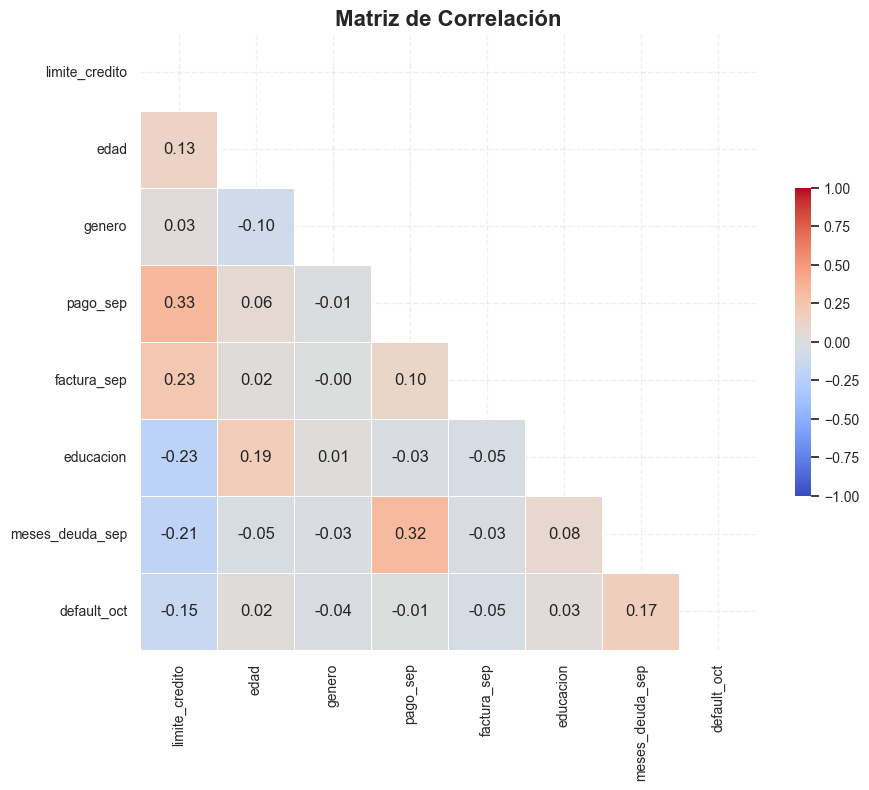

In [7]:
cols = ['limite_credito', 'edad', 'genero', 'pago_sep', 'factura_sep','educacion','meses_deuda_sep', 'default_oct']

corr = df[cols].corr()

plt.figure(figsize=(10, 8)) 

sns.heatmap(corr, 
            mask=np.triu(np.ones_like(corr, dtype=bool)), # Máscara para no generar el triangulo superior
            cmap='coolwarm', 
            vmax=1, vmin=-1,
            center=0, 
            square=True, 
            linewidths=.5, 
            cbar_kws={"shrink": .5},
            annot=True,
            fmt=".2f")

plt.title('Matriz de Correlación', fontsize=16)
plt.show()

**Observaciones:**
- La variable `meses_deuda_sep` tiene la **correlación positiva** más fuerte con nuestro *target* `default_oct` (0.17). Cuantos más meses de deuda arrastra el cliente, más probabilidad de default.
- La variable `limite_credito` tiene la **correlación negativa** más fuerte con `default_oct` (-0.15). A mayor límite de crédito, menor default. Esto valida que el banco asigna límites más altos a los clientes más confiables.
- Las variables de `pago_sep` y `factura_sep` no tienen prácticamente relación lineal con nuestra variable objetivo. 
- La variable `limite_credito` tiene una correlación negativa con `educacion` de -0.23, lo cual indica que a menor nivel educativo el Banco toma más recaudos a la hora de otorgar una línea de crédito.

A continuación gráficamos un histograma junto a la curva de densidad para verificar la correlación entre el límite de crédito y el estado de default:

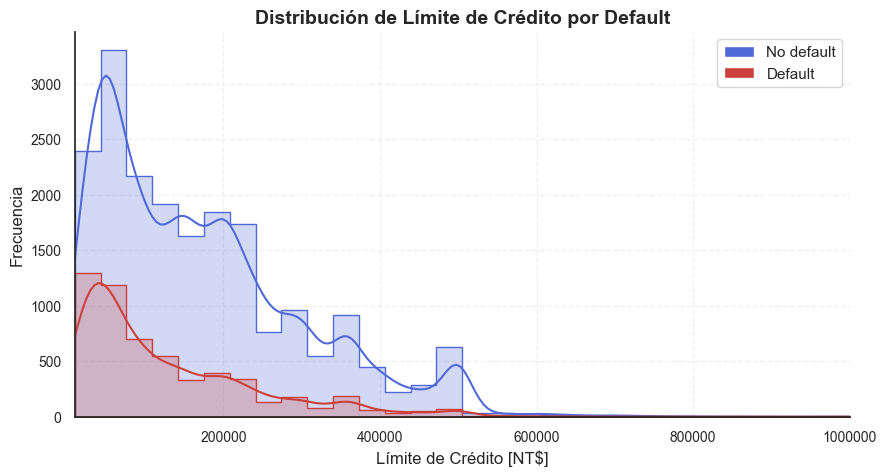

In [44]:
from matplotlib.patches import Patch
plt.figure(figsize=(10, 5))

sns.histplot(data=df_vis, x='limite_credito', hue='default_oct', bins=30, kde=True, element='step', palette={'No Default': "#4F69D9", 'Default': "#CC403A"})

plt.xlim(np.min(df_vis['limite_credito']), 1_000_000)
plt.title('Distribución de Límite de Crédito por Default')
plt.ylabel('Frecuencia')
plt.xlabel('Límite de Crédito [NT$]')
plt.ticklabel_format(style='plain', axis='x')
legend_elements = [
    Patch(facecolor='#4F69D9', label='No default'),
    Patch(facecolor='#CC403A', label='Default')
]
plt.legend(title='', handles=legend_elements)
plt.show()

**Observaciones:**


Luego gráficamos las frecuencias de ocurrencia de los defaults entre las distintas situaciones de deuda para verificar la correlación entre los meses de deuda y el estado de default:

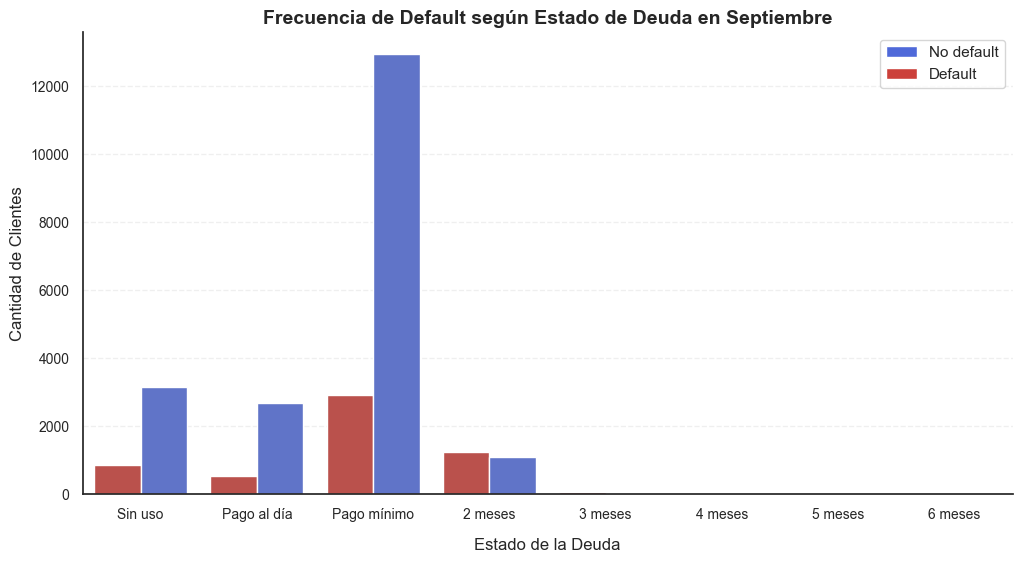

In [41]:
plt.figure(figsize=(12, 6))

# Ordenamos el eje X para que tenga sentido visual
orden_logico = ['Sin uso', 'Pago al día', 'Pago mínimo','2 meses', '3 meses', '4 meses', '5 meses', '6 meses'] 

sns.countplot(data=df_vis, x='meses_deuda_sep', hue='default_oct', 
              order=orden_logico,
              palette={'No Default': "#4F69D9", 'Default': "#CC403A"})

plt.title('Frecuencia de Default según Estado de Deuda en Septiembre')
plt.ylabel('Cantidad de Clientes')
plt.xlabel('Estado de la Deuda', labelpad=12)
plt.legend(title='', handles=legend_elements)
plt.show()


Por último exploramos con un boxplot la relación entre el límite de crédito y el nivel educativo de los clientes, y cómo impactan esas dos variables en el estado de default de octubre:

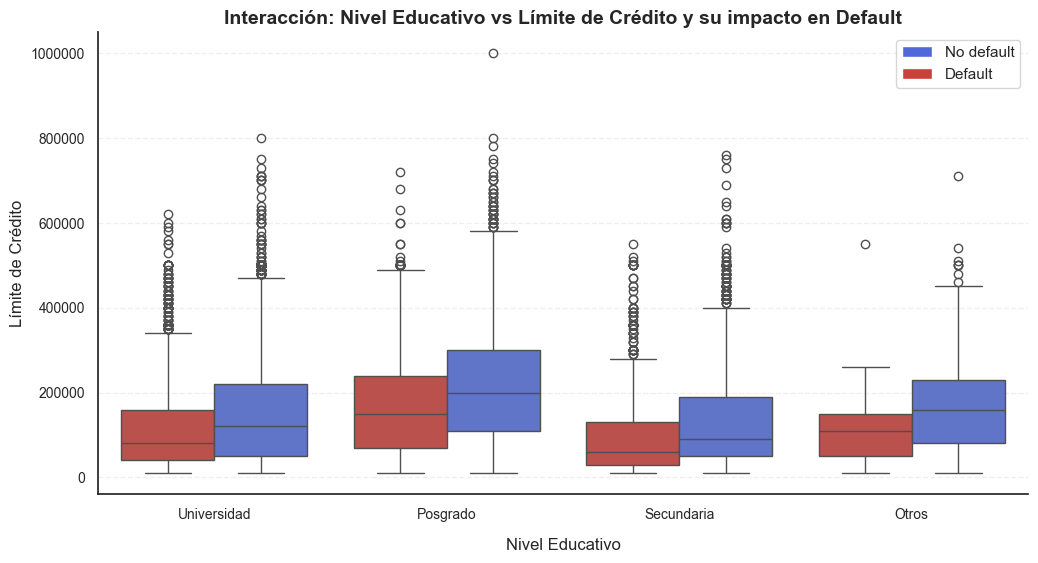

In [42]:
plt.figure(figsize=(12, 6))

sns.boxplot(data=df_vis, x='educacion', y='limite_credito', hue='default_oct', palette={'No Default': "#4F69D9", 'Default': "#CC403A"})

plt.title('Interacción: Nivel Educativo vs Límite de Crédito y su impacto en Default')
plt.xlabel('Nivel Educativo', labelpad=12)
plt.ylabel('Límite de Crédito')
plt.ticklabel_format(style='plain', axis='y')
plt.legend(title='', handles=legend_elements)
plt.show()

### 3. Conclusiones y Próximos Pasos